# 08_evaluation_reporting — Metrics, Scenarios, Figures
This notebook aggregates **forecast metrics**, evaluates **risk alerts** (rule vs BN), and exports **case‑study plots/tables** for your report.

**Inputs (produced earlier):**
- `features_daily.csv` or `master_with_topics.csv` (must have `date`, hydrology columns, flags)
- `predictions_test.csv` (must have `date`, `y_true`, `gpr_mean`, `gpr_std`)
- `decision_recommendations.csv` (from 06)
- `bn_inference.csv` (from 07)

**Outputs:**
- `final_metrics.csv` (model metrics table)
- `case_studies.csv` (scenario slices)
- `figures/` (PNG plots ready for the paper)

## 1) Imports & configuration

In [1]:

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

plt.rcParams['figure.figsize'] = (11,4)

# ---- paths (edit if your filenames differ) ----
FEATURES_PATH = "master_with_topics.csv"  # or "features_daily.csv"
PRED_PATH     = "predictions_test.csv"
RULE_PATH     = "decision_recommendations.csv"
BN_PATH       = "bn_inference.csv"

FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)
METRICS_OUT = "final_metrics.csv"
SCENARIOS_OUT = "case_studies.csv"

# thresholds
THR_MED, THR_HIGH = 0.35, 0.60

for p in [FEATURES_PATH, PRED_PATH, RULE_PATH, BN_PATH]:
    print(Path(p).resolve())

C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\master_with_topics.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\predictions_test.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\decision_recommendations.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\bn_inference.csv


## 2) Load & merge

In [2]:

# Load what exists
def rd(p): 
    fp = Path(p)
    return pd.read_csv(fp, parse_dates=['date']) if fp.exists() else None

feat = rd(FEATURES_PATH)
pred = rd(PRED_PATH)
rule = rd(RULE_PATH)
bn   = rd(BN_PATH)

# Merge progressively on 'date'
df = None
for d in [feat, pred, rule, bn]:
    if d is None: 
        continue
    df = d if df is None else df.merge(d, on='date', how='outer')

df = df.sort_values('date').reset_index(drop=True)
print("Rows:", len(df))
df.head(3)

Rows: 1796


,date,discharge_m3s,reservoir_m,rainfall_mm,load_MW,avg_load_mw,energy_mwh,year,doy,dow,...,risk_spill,risk_highload,risk_shortfall,risk_maint_defer,decision_x,rationale,P(RiskSpill=1),P(RiskShortfall=1),P(RiskHighLoad=1),decision_y
0,2019-01-31,120.0,0.64,0.0,1428.760,946.092065,28941.248,2019.0,31,3,...,0.400503,0.5,0.5,0.400503,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.,0.00147,0.998588,0.998588,Shortfall mitigation (imports/DR)
1,2019-02-01,132.0,0.72,0.0,1437.155,970.446968,29686.272,2019.0,32,4,...,0.515009,0.5,0.5,0.515009,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.,0.00147,0.998588,0.998588,Shortfall mitigation (imports/DR)
2,2019-02-02,131.0,0.71,0.0,1395.755,967.499629,29596.112,2019.0,33,5,...,0.510859,0.5,0.5,0.510859,Monitor inflows; pre-position spillway crew,Moderate spill risk; ensure readiness.,0.00147,0.998588,0.998588,Shortfall mitigation (imports/DR)


## 3) Forecast metrics (RMSE/MAE/MAPE & PI coverage)

In [4]:

## 3) Forecast metrics (RMSE/MAE/MAPE & PI coverage)
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    mask = (y != 0) & np.isfinite(y) & np.isfinite(yhat)
    return np.mean(np.abs((yhat[mask] - y[mask]) / y[mask]))*100 if mask.any() else np.nan

metrics_rows = []

if pred is not None and {'y_true','gpr_mean'}.issubset(pred.columns):
    y = pred.set_index('date')['y_true']
    yhat = pred.set_index('date')['gpr_mean']

    # align indices and drop NaNs
    idx = y.dropna().index.intersection(yhat.dropna().index)
    y, yhat = y.loc[idx], yhat.loc[idx]

    # compute metrics (compat with older sklearn: no 'squared' kwarg)
    mse  = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, yhat)
    mp   = mape(y, yhat)

    # 95% prediction interval coverage (if std available)
    cov = np.nan
    if 'gpr_std' in pred.columns:
        s = pred.set_index('date').loc[idx, 'gpr_std'].clip(lower=1e-6)
        lo, up = yhat - 1.96*s, yhat + 1.96*s
        cov = ((y >= lo) & (y <= up)).mean()*100

    metrics_rows.append(['GP (non-load)', rmse, mae, mp, cov])

metrics = pd.DataFrame(metrics_rows, columns=['model','rmse','mae','mape_%','pi_95_coverage_%'])
metrics.to_csv(METRICS_OUT, index=False)
print("Saved", METRICS_OUT)
metrics


Saved final_metrics.csv


,model,rmse,mae,mape_%,pi_95_coverage_%
0,GP (non-load),129.282911,101.159871,5.937984,91.242938


## 4) Risk alert evaluation (rule vs BN)

In [5]:

load_col = None
if feat is not None:
    for c in ['load_MW','peak_load_mw','avg_load_mw']:
        if c in feat.columns:
            load_col = c; break

if load_col is None and pred is not None and 'y_true' in pred.columns:
    base = pred[['date','y_true']].rename(columns={'y_true':'load_ref'})
else:
    base = feat[['date',load_col]].rename(columns={load_col:'load_ref'}) if feat is not None else None

eval_rows = []
if base is not None:
    cap = base['load_ref'].quantile(0.95)
    minv = base['load_ref'].quantile(0.10)
    base['gt_highload'] = (base['load_ref'] >= cap).astype(int)
    base['gt_shortfall'] = (base['load_ref'] <= minv).astype(int)

    if rule is not None:
        x = base.merge(rule[['date','risk_highload','risk_shortfall']], on='date', how='left')
        def pr_re(y_true, score):
            thr = THR_HIGH
            yhat = (x[score] >= thr).astype(int)
            tp = ((x[y_true]==1) & (yhat==1)).sum()
            fp = ((x[y_true]==0) & (yhat==1)).sum()
            fn = ((x[y_true]==1) & (yhat==0)).sum()
            prec = tp/(tp+fp) if (tp+fp)>0 else np.nan
            rec = tp/(tp+fn) if (tp+fn)>0 else np.nan
            return prec, rec
        ph, rh = pr_re('gt_highload','risk_highload')
        ps, rs = pr_re('gt_shortfall','risk_shortfall')
        eval_rows.append(['rule', 'highload', ph, rh])
        eval_rows.append(['rule', 'shortfall', ps, rs])

    if bn is not None:
        y = base.merge(bn[['date','P(RiskHighLoad=1)','P(RiskShortfall=1)']], on='date', how='left')
        for tgt, col in [('gt_highload','P(RiskHighLoad=1)'), ('gt_shortfall','P(RiskShortfall=1)')]:
            yhat = (y[col] >= THR_HIGH).astype(int)
            tp = ((y[tgt]==1) & (yhat==1)).sum()
            fp = ((y[tgt]==0) & (yhat==1)).sum()
            fn = ((y[tgt]==1) & (yhat==0)).sum()
            prec = tp/(tp+fp) if (tp+fp)>0 else np.nan
            rec = tp/(tp+fn) if (tp+fn)>0 else np.nan
            eval_rows.append(['bn', col, prec, rec])

eval_df = pd.DataFrame(eval_rows, columns=['system','target','precision','recall'])
eval_df

,system,target,precision,recall
0,rule,highload,NaN,0.000000
1,rule,shortfall,NaN,0.000000
2,bn,P(RiskHighLoad=1),0.009709,0.160920
3,bn,P(RiskShortfall=1),0.116505,0.965517


## 5) Scenario slices & figures

Saved case_studies.csv | rows: 719


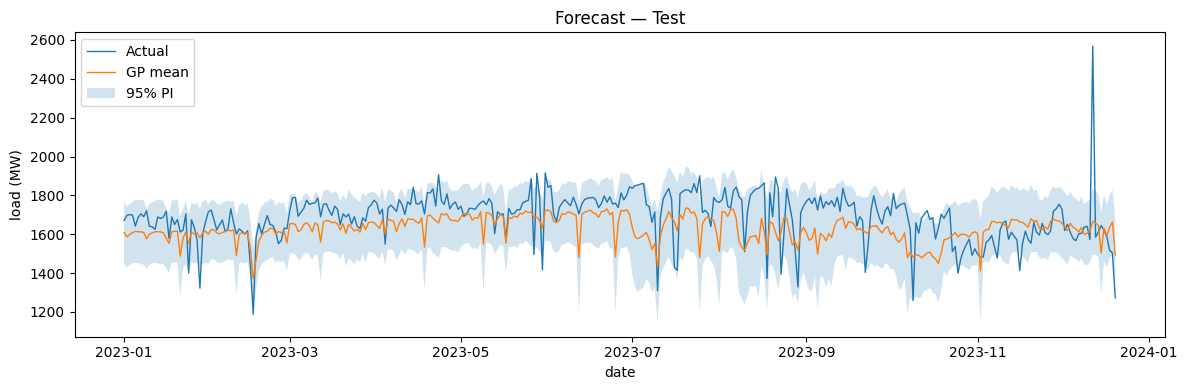

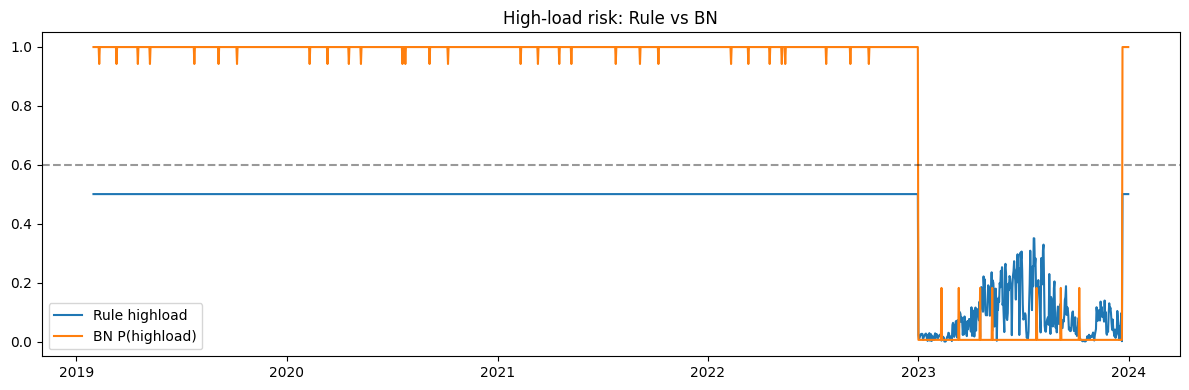

In [6]:

full = df.copy()

def month_in(m1,m2): 
    return full['date'].dt.month.between(m1,m2)

scenarios = []
if 'rainfall_mm' in full.columns:
    monsoon = full.loc[month_in(6,9)].copy(); monsoon['scenario'] = 'monsoon'
    scenarios.append(monsoon)

if 'maintenance_flag' in full.columns or 'outage_flag' in full.columns:
    maint = full.loc[(full.get('maintenance_flag',0)+full.get('outage_flag',0))>0].copy()
    maint['scenario']='maintenance/outage'
    scenarios.append(maint)

if pred is not None and 'y_true' in pred.columns:
    ref = pred[['date','y_true']].rename(columns={'y_true':'load_ref'})
    hi = ref[ref['load_ref']>=ref['load_ref'].quantile(0.9)].merge(full, on='date', how='left')
    hi['scenario'] = 'peak_load_top10%'; scenarios.append(hi)
    lo = ref[ref['load_ref']<=ref['load_ref'].quantile(0.1)].merge(full, on='date', how='left')
    lo['scenario'] = 'low_load_bot10%'; scenarios.append(lo)

cases = pd.concat(scenarios, ignore_index=True) if scenarios else pd.DataFrame(columns=['date','scenario'])
cases.to_csv(SCENARIOS_OUT, index=False)
print("Saved", SCENARIOS_OUT, "| rows:", len(cases))

# Example figure: forecasts vs actual (test period)
if pred is not None and {'y_true','gpr_mean'}.issubset(pred.columns):
    p = pred.sort_values('date')
    plt.figure(figsize=(12,4))
    plt.plot(p['date'], p['y_true'], label='Actual', lw=1)
    plt.plot(p['date'], p['gpr_mean'], label='GP mean', lw=1)
    if 'gpr_std' in p.columns:
        lo, up = p['gpr_mean']-1.96*p['gpr_std'], p['gpr_mean']+1.96*p['gpr_std']
        plt.fill_between(p['date'], lo, up, alpha=0.2, label='95% PI')
    plt.title('Forecast — Test'); plt.xlabel('date'); plt.ylabel('load (MW)')
    plt.legend(); plt.tight_layout()
    plt.savefig(FIG_DIR/'forecast_test.png', dpi=160)
    plt.show()

# Example figure: BN vs rule risks (if both available)
if (rule is not None) and (bn is not None):
    merged = rule.merge(bn, on='date', how='inner')
    plt.figure(figsize=(12,4))
    if 'risk_highload' in merged.columns: 
        plt.plot(merged['date'], merged['risk_highload'], label='Rule highload')
    if 'P(RiskHighLoad=1)' in merged.columns:
        plt.plot(merged['date'], merged['P(RiskHighLoad=1)'], label='BN P(highload)')
    plt.axhline(THR_HIGH, color='k', ls='--', alpha=0.4)
    plt.title('High‑load risk: Rule vs BN'); plt.legend(); plt.tight_layout()
    plt.savefig(FIG_DIR/'risk_highload_rule_vs_bn.png', dpi=160)
    plt.show()